<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/DATAPREPARATION_gpt_3dot5_finetunning_AviationQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [ ]:
# Install Pytorch & other libraries
!pip install torch tensorboard --quiet

# Install Hugging Face libraries
!pip install  --upgrade transformers datasets accelerate evaluate bitsandbytes --quiet

#FlashAttention only supports Ampere GPUs or newer. #NEED A100 IN GOOGLE COLAB
#!pip install -U transformers
# Uncomment only if you're using A100 GPU
!pip install -U flash-attn --no-build-isolation --quiet


! pip install peft --quiet
! pip install datasets trl ninja packaging --quiet

!pip install diffusers safetensors  --quiet
!pip install colab-env --quiet


In [2]:
!nvidia-smi

Fri Jun  7 04:54:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import colab_env

Mounted at /content/gdrive


In [4]:
#load all libraries
import requests
import json
import torch
import torch.nn as nn
import os
from tqdm import tqdm
from transformers import AdamW
#from transformers import BertModel, BertTokenizerFast, AdamW
# AutoTokenizer, AutoModelForQuestionAnswering, BertTokenizer, BertForQuestionAnswering
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

In [ ]:
#MODEL_PATH = "bert-base-uncased"

## Load Dataset

In [5]:
def create_prompt_formats(sample):
    """
    Format various fields of the sample ('instruction','output')
    Then concatenate them using two newline characters
    :param sample: Sample dictionnary
    """
    INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    INSTRUCTION_KEY = "### Instruct: Summarize the below conversation."
    RESPONSE_KEY = "### Output:"
    END_KEY = "### End"

    blurb = f"\n{INTRO_BLURB}"


In [50]:
from datasets import load_dataset
print("Preprocessing dataset AviationQA")
dataset = load_dataset("sakharamg/AviationQA")

dataset = dataset.map(create_prompt_formats)

# save datasets to disk
dataset["train"].to_json("train_dataset_AviationQA.json", orient="records")
dataset["validation"].to_json("validation_dataset_AviationQA.json", orient="records")
dataset["test"].to_json("test_dataset_AviationQA.json", orient="records")

Preprocessing dataset AviationQA


Map:   0%|          | 0/1057986 [00:00<?, ? examples/s]

Map:   0%|          | 0/11888 [00:00<?, ? examples/s]

Map:   0%|          | 0/10807 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1058 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

1618145

In [7]:
from datasets import load_dataset
dataset = load_dataset("json", data_files="/content/train_dataset_AviationQA.json", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
dataset_valid = load_dataset("json", data_files="/content/validation_dataset_AviationQA", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [9]:
print(dataset)

Dataset({
    features: ['id', 'Question', 'Answer'],
    num_rows: 1057986
})


In [10]:
print(dataset_valid)

Dataset({
    features: ['id', 'Question', 'Answer'],
    num_rows: 11888
})


In [11]:
train_question=dataset['Question']
train_answer=dataset['Answer']

In [12]:
valid_question=dataset_valid['Question']
valid_answer=dataset_valid['Answer']

In [74]:
train_numberofquestions = len(train_question)
train_numberofquestions

1057986

In [75]:
valid_numberofquestions = len(valid_question)
valid_numberofquestions

11888

In [76]:
{"messages": [{"role": "system", "content": "AviBot is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}]}
#{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "Who wrote 'Romeo and Juliet'?"}, {"role": "assistant", "content": "Oh, just some guy named William Shakespeare. Ever heard of him?"}]}
#{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "How far is the Moon from Earth?"}, {"role": "assistant", "content": "Around 384,400 kilometers. Give or take a few, like that really matters."}]}

{'messages': [{'role': 'system',
   'content': 'AviBot is a factual chatbot that is also sarcastic.'},
  {'role': 'user', 'content': "What's the capital of France?"},
  {'role': 'assistant',
   'content': "Paris, as if everyone doesn't know that already."}]}

In [77]:
n=100
print(valid_question[n])

What is the Certified Max Gross Wt. of the accident no. GAA17CA108?


In [80]:
print(train_answer[n])

February 3, 2020,


In [ ]:
for n in range(100):
    print(n)

In [ ]:
!rm -rf /content/gdrive/MyDrive/datasets/aviation.jsonl
import json


filename='/content/gdrive/MyDrive/datasets/aviation.jsonl'
# python object to be appended
for n in range(10000):
    if train_answer[n] == None:
       train_answer[n] = 'Not possible to get or use'
    m={"messages": [{"role": "system", "content": "AviBot is a factual chatbot that is also sarcastic."}, {"role": "user", "content": train_question[n]}, {"role": "assistant", "content": train_answer[n], "weight": 0}, {"role": "user", "content": "Can you be more sarcastic?"}, {"role": "assistant", "content": "%s, as if everyone doesn't know that already."%train_answer[n], "weight": 1}]}
    print(m)
    with open(filename,'a') as file:  # Changed to 'w' to overwrite and ensure valid JSON
        # Corrected the json.dump() call by passing the file object as the first argument
        json.dump(m, file)
        file.write('\n')

In [20]:
print(m)

{'messages': [{'role': 'system', 'content': 'AviBot is a factual chatbot that is also sarcastic.'}, {'role': 'user', 'content': 'What is the Airplane Rating(s) of the accident no. CEN19LA232?'}, {'role': 'assistant', 'content': 'Single-engine land; Single-engine sea; Multi-engine land', 'weight': 0}, {'role': 'user', 'content': 'Can you be more sarcastic?'}, {'role': 'assistant', 'content': "Single-engine land; Single-engine sea; Multi-engine land, as if everyone doesn't know that already.", 'weight': 1}]}


In [21]:
print(train_question[0:2])
print(train_answer[0:2])

['Where was the Destination of the accident no. DCA21LA096?', 'What is the name of the Engine Manufacturer of the accident no. ANC13LA068?']
['Los Angeles, CA', 'Pratt & Whitney']


In [22]:
print(valid_question[0:2])
print(valid_answer[0:2])

['Are there Other Aircraft Rating(s) for the pilot of the accident no. ERA10LA391?', 'What was the Wreckage and Impact Information Crew Injuries of the accident no. CEN13CA223?']
[None, '1 None']


In [82]:
print(f"Total number of questions: {len(train_question)}")
print(f"Total number of not Answerable questions: {num_posible}")

Total number of questions: 1057986
Total number of not Answerable questions: 0


## Tokenize

### Find max lengths

17
1057986


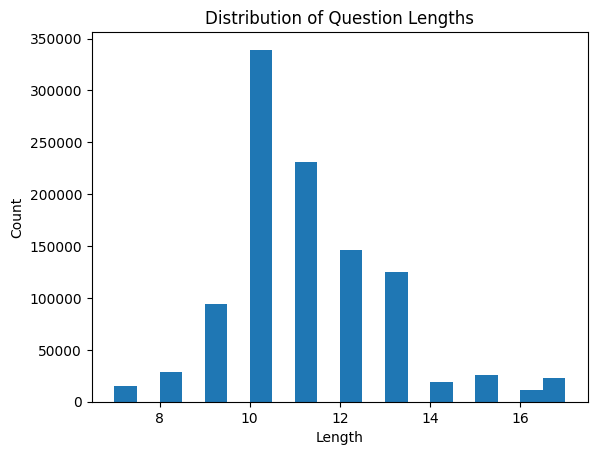

In [144]:
#Test lengths of Questions
token_lens2 = []

for txt in train_question:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens2.append(len(txt.split(' ')))


print(max(token_lens2))
print(len(token_lens2))

plt.hist(token_lens2,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Question Lengths');

In [56]:
MAX_LENGTH = 250

### tokenize

In [ ]:
#!pip install trl --quiet
#!pip install accelerate --quiet

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from trl import setup_chat_format

# Hugging Face model id
model_id = "mistralai/Mistral-7B-Instruct-v0.1" #01 march 2024
#model_id = "mistralai/Mixtral-8x7B-Instruct-v0.1" # 04/03/2024

#model_id = "abacusai/Smaug-72B-v0.1" #04 march 2024
#model_id = "codellama/CodeLlama-7b-hf"

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    #attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
tokenizerFast = AutoTokenizer.from_pretrained(model_id,use_fast=True)
tokenizerFast.padding_side = 'right' # to prevent warnings

# We redefine the pad_token and pad_token_id with out of vocabulary token (unk_token)
tokenizerFast.pad_token = tokenizerFast.unk_token
tokenizerFast.pad_token_id = tokenizerFast.unk_token_id

# # set chat template to OAI chatML, remove if you start from a fine-tuned model
model, tokenizerFast = setup_chat_format(model, tokenizerFast)

In [72]:
#tokenizerFast = BertTokenizerFast.from_pretrained(MODEL_PATH)

train_encodings_fast = tokenizerFast(train_question,  max_length = MAX_LENGTH, truncation=True, padding=True)
valid_encodings_fast = tokenizerFast(valid_question,  max_length = MAX_LENGTH, truncation=True, padding=True)


In [59]:
type(train_encodings_fast)

transformers.tokenization_utils_base.BatchEncoding

In [73]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['input_ids'][0]))

dict_keys(['input_ids', 'attention_mask'])
dict_keys(['input_ids', 'attention_mask'])
1057986
32


In [62]:
print(train_encodings_fast['input_ids'][0])

[1, 6926, 403, 272, 14466, 2235, 302, 272, 8318, 708, 28723, 384, 5194, 28750, 28740, 8423, 28734, 28774, 28784, 28804, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001]


In [63]:
type(train_answer[0])
#train_answer[0].keys()

str

In [65]:
train_answer_encodings_fast = tokenizerFast(train_answer[0],  max_length = MAX_LENGTH, truncation=True, padding=True)


In [182]:
def ret_Answer_start_and_end_train(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(train_answer[idx],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(train_encodings_fast['input_ids'][idx]) -  len(answer_encoding_fast['input_ids']) ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            #print(len(answer_encoding_fast['input_ids']))
            #print(answer_encoding_fast[i])
            if (answer_encoding_fast['input_ids'][i] != train_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            if 'i' in locals():
                #print(i)
                i=i
            else:
                i=0

            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)


In [183]:
test_rec=100

z,x = ret_Answer_start_and_end_train(test_rec)
#print(z, x)

predict_answer_tokens = train_encodings_fast.input_ids[test_rec][z : x]
#print(tokenizerFast.decode(predict_answer_tokens))


print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))
print(train_answer[test_rec])

<s> What was the date and time of the accident no.ENG20RA030?<|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|>
February 3, 2020,


In [172]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'attention_mask'])
dict_keys(['input_ids', 'attention_mask'])
1057986


In [95]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'attention_mask'])
dict_keys(['input_ids', 'attention_mask'])
1057986


In [175]:
test_rec = 2
print(train_encodings_fast[test_rec])
print(train_encodings_fast[test_rec])
predict_answer_tokens = train_encodings_fast.input_ids[test_rec]

print()
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answer[test_rec])
#print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

Encoding(num_tokens=32, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
Encoding(num_tokens=32, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

<s> Who determines the probable cause(s) of this accident no. ERA22LA104?<|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|>
The National Transportation Safety Board


In [176]:
def ret_Answer_start_and_end_valid(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(valid_answer[idx],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(valid_encodings_fast['input_ids'][idx])  -  len(answer_encoding_fast['input_ids'])   ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            if (answer_encoding_fast['input_ids'][i] != valid_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            if 'i' in locals():
                #print(i)
                i=i
            else:
                i=0
            #i=0
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)

In [177]:
test_rec=2

z,x = ret_Answer_start_and_end_valid(test_rec)

predict_answer_tokens = valid_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(valid_answer[test_rec])
print(tokenizerFast.decode(valid_encodings_fast['input_ids'][test_rec]))


Airplane single-engine; Instrument airplane
<s> Are there Rating(s) for pilot's instructor available for the accident no. GAA16CA229?<|im_end|><|im_end|><|im_end|><|im_end|><|im_end|>


In [178]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
#print(len(train_encodings_fast['start_positions']))
#print(len(train_encodings_fast['end_positions']))
print(len(valid_encodings_fast['input_ids']))
#print(len(valid_encodings_fast['start_positions']))
#print(len(valid_encodings_fast['end_positions']))

dict_keys(['input_ids', 'attention_mask'])
dict_keys(['input_ids', 'attention_mask'])
1057986
11888


In [ ]:
#tokenizerFast.decode(train_encodings_fast['input_ids'][0])

In [179]:
tokenizerFast.decode(train_encodings_fast['input_ids'][0])

'<s> Where was the Destination of the accident no. DCA21LA096?<|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|>'